# Load Dataset

In [1]:
import pandas as pd
import azureml.core
from azureml.core import Dataset, Datastore, Workspace

ws = Workspace.from_config()

qualitydf = Dataset.get_by_name(workspace=ws,name="iiot_quality_labeled_data").to_pandas_dataframe()
print("Rows => {0}".format(qualitydf.shape[0]))
print("Columns => {0}".format(qualitydf.shape[1]))
qualitydf.head()

Rows => 7711
Columns => 44


,BatchNumber,S1,S10,S11,S12,S13,S14,S15,S16,S17,...,S4,S40,S41,S5,S6,S7,S8,S9,SourceTimestamp,Quality
0,7423.0,4.998839,39.5,21.9,866.6161,2046.699,2089.468,943.1278,22.02698,25.83976,...,None,9501.005,7221.264648,4.999668,5.050548,23.57390,27.6,36.1,2022-05-05 00:40:20.077,1
1,7424.0,4.999668,39.4,21.8,893.7124,2052.430,2069.875,930.0323,22.02698,25.67179,...,None,9501.005,7213.028320,4.999668,5.056084,23.60346,27.7,35.9,2022-05-05 00:40:22.084,1
2,7425.0,4.999668,39.5,21.9,894.3060,2060.232,2075.162,930.1899,22.36291,25.83976,...,None,9501.005,7229.500977,4.999668,5.048703,23.57944,28.1,35.9,2022-05-05 00:40:24.091,1
3,7426.0,4.999668,39.6,21.9,876.8541,2046.037,2137.928,943.1278,22.19494,25.67179,...,None,9501.005,7213.028320,4.999668,5.047780,23.60447,28.4,35.9,2022-05-05 00:40:26.098,1
4,7427.0,4.999668,39.6,22.1,895.3438,2033.450,2090.136,943.4471,22.02698,25.83976,...,None,9501.005,7229.500977,4.999668,5.045012,23.64226,28.8,36.1,2022-05-05 00:40:28.105,1


# Examine missing values for all sensors

Next we can look at the number and percentage of missing values in each column.

In [2]:
def getMissingValues(df):
    totalMissingValues = df.isnull().sum()
    percentageMissingValues = 100 * df.isnull().sum() / len(df)
    missingValueTable = pd.concat([totalMissingValues, percentageMissingValues], axis=1).rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    missingValueTable = missingValueTable[missingValueTable.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)    
    print ("Total " + str(df.shape[1]) + " columns")
    print(str(missingValueTable.shape[0]) + " columns with missing values.")
    return missingValueTable

missingValuesdf = getMissingValues(qualitydf)
missingValuesdf.head(10) 

Total 44 columns
5 columns with missing values.


,Missing Values,% of Total Values
S4,5505,71.4
S3,34,0.4
S2,6,0.1
S28,2,0.0
S26,1,0.0


In [3]:
# Remove missing values column with more than 50% total values missing
qualitydf.drop('S4', axis=1, inplace=True)

missingValuesdf = getMissingValues(qualitydf)
missingValuesdf.head(10) 

Total 43 columns
4 columns with missing values.


,Missing Values,% of Total Values
S3,34,0.4
S2,6,0.1
S28,2,0.0
S26,1,0.0


# Examine distriution of the Target Column

The target is what we are asked to predict, which in our case is Quality, and that column has two values 0 and 1. (example, quality error codes)

1 = Meets quality expectations

0 = Does not meet quality expectation.

The goal is to understand if our labeled data is skewed, and apply different class imbalance techniques if needed later on during modeling phase.


1    6323
0    1388
Name: Quality, dtype: int64


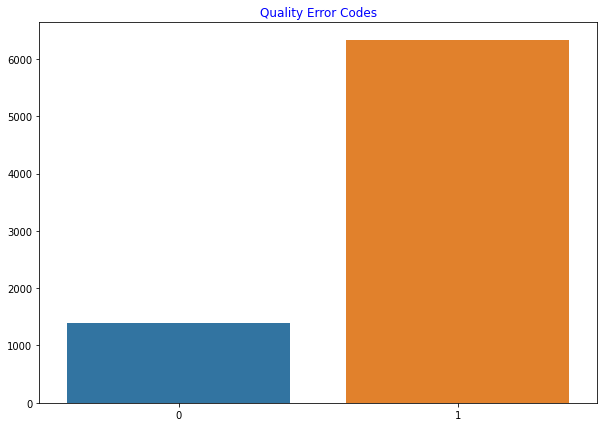

In [4]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Visualize distribution for y
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

ydata = qualitydf['Quality'].value_counts()
print(ydata)
sns.barplot(x=ydata.index,y=ydata.values)
plt.title('Quality Error Codes',color = 'blue')
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.show()

# Examine data distribution for each sensor

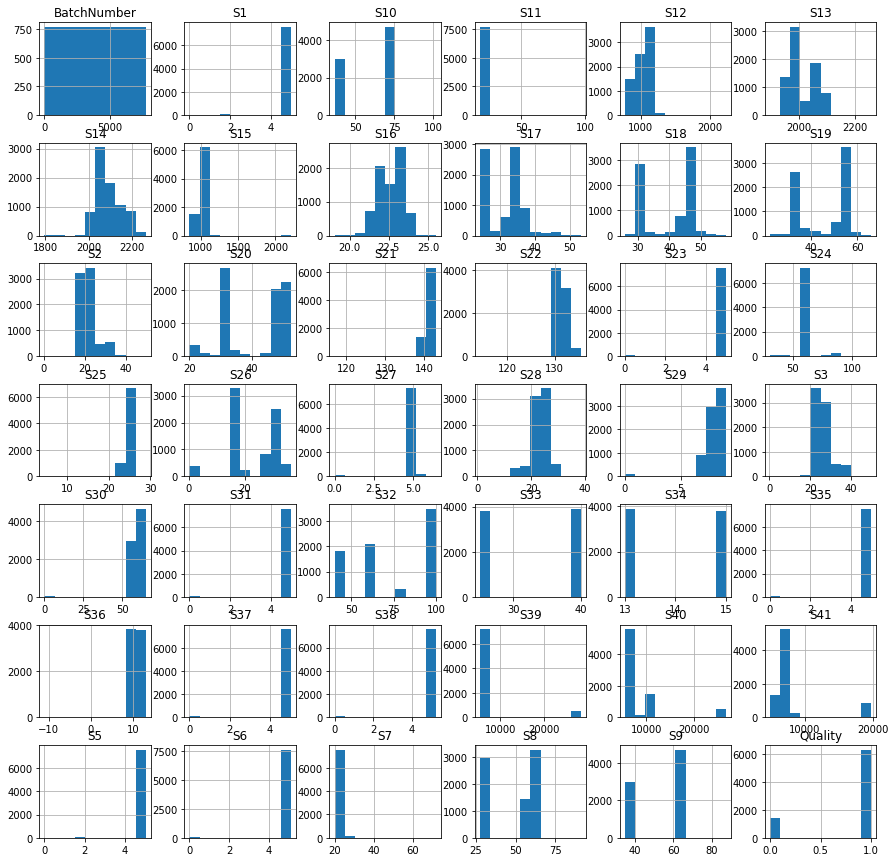

In [5]:
fig_size = plt.rcParams["figure.figsize"] 
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
qualitydf.hist()
plt.show()

# Examine Outliers for each sensor

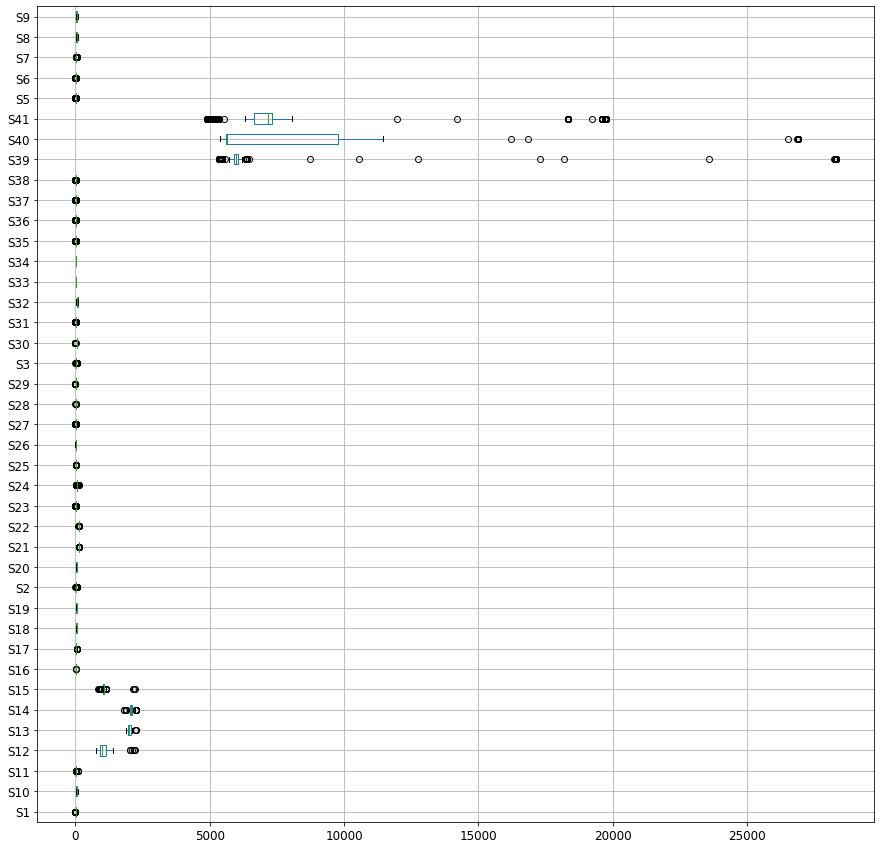

In [6]:
boxplot = qualitydf[qualitydf.columns.difference(['BatchNumber','Quality'])].boxplot(vert=False,fontsize=12)

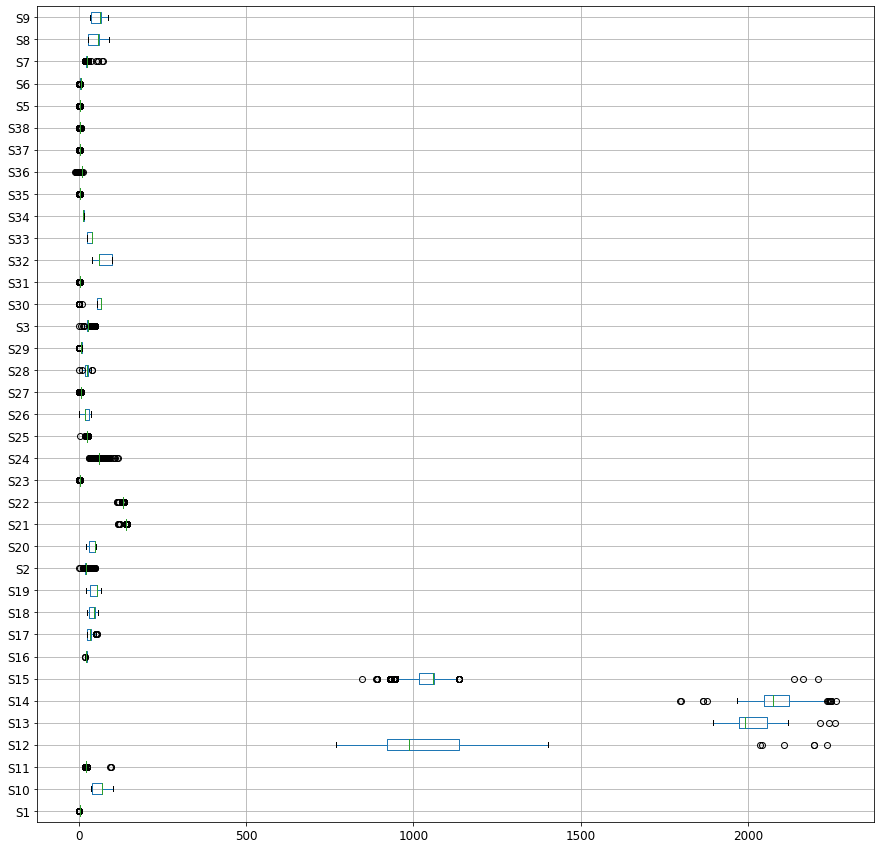

In [7]:
boxplot = qualitydf[qualitydf.columns.difference(['BatchNumber','Quality','S39','S40','S41'])].boxplot(vert=False,fontsize=12)

# Correlation

One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.
The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. 

Some general interpretations of the absolute value of the correlation coefficent are:

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [8]:
# Find correlations with the target and sort
correlations = qualitydf.corr()['Quality'].sort_values()

# Display correlations
print('Most Positive Correlations:\n---------------------\n', correlations.tail(10).sort_values(ascending=False))
print('\nMost Negative Correlations:\n---------------------\n', correlations.head(10))

Most Positive Correlations:
---------------------
 Quality        1.000000
BatchNumber    0.055867
S16            0.053868
S20            0.045348
S19            0.039865
S18            0.035863
S29            0.034034
S41            0.028061
S9             0.027156
S10            0.026320
Name: Quality, dtype: float64

Most Negative Correlations:
---------------------
 S11   -0.064857
S14   -0.051640
S13   -0.041795
S28   -0.040426
S15   -0.037958
S26   -0.029860
S33   -0.025911
S7    -0.025344
S3    -0.010728
S39   -0.006763
Name: Quality, dtype: float64


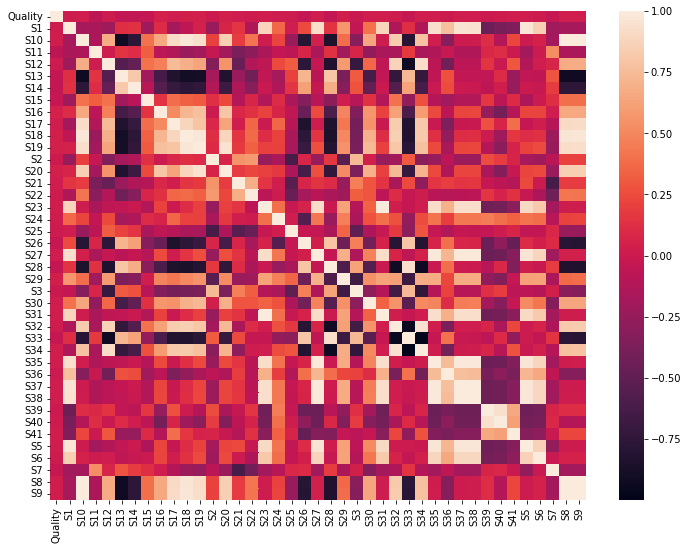

In [9]:
# Visualize correlation map
corrmat = qualitydf[qualitydf.columns.difference(['BatchNumber'])].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,annot=False);
plt.show()

# Select initial sensors for Quality prediction based on above analysis

Feature selection is a key exercise and requires some more deeper understanding data analysis. In this sample we are just using the correlation values to select our initial features. We can also use all the available sensor value as Features but limiting the number of features helps us understand the model better and we can always add more features as needed to improve our model.

In [10]:
feature_correlations = correlations.drop(labels=['BatchNumber'])
top_positive_features = feature_correlations.tail(10).sort_values(ascending=False)
top_negative_features = feature_correlations.head(10)

selectedFeatures = top_positive_features.append(top_negative_features)

print("Selected features:\n-----------------------------")
print(selectedFeatures.index.values)

Selected features:
-----------------------------
['Quality' 'S16' 'S20' 'S19' 'S18' 'S29' 'S41' 'S9' 'S10' 'S8' 'S11' 'S14'
 'S13' 'S28' 'S15' 'S26' 'S33' 'S7' 'S3' 'S39']


# Analyze Selected Features

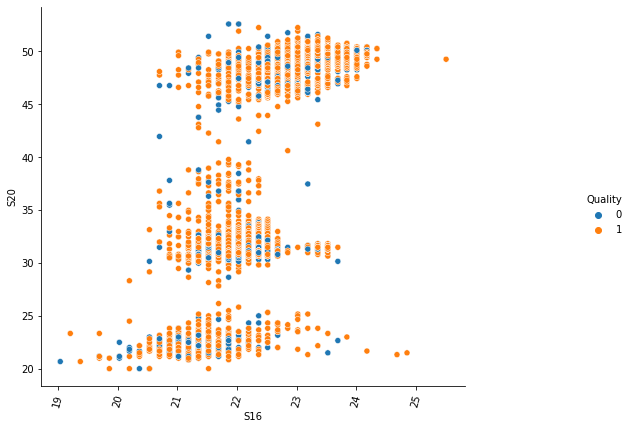

In [11]:
sns.pairplot(x_vars=['S16'], y_vars=['S20'], data=qualitydf, hue='Quality', diag_kind = 'kde')
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.xticks(rotation=75)
plt.show()

# Register new dataset with selected features

In [13]:
import os
from azureml.data.datapath import DataPath

finalQualitydf = qualitydf[selectedFeatures.index]

localDataDirectoryName = "data"
datasetFileName = "iiot_quality_featured_data.csv"
data_folder = os.path.join(os.getcwd(), localDataDirectoryName)
os.makedirs(data_folder, exist_ok=True)

# Save dataframe to local file
finalQualitydf.to_csv("{0}/{1}".format(data_folder,datasetFileName),index=False)

# Upload file to Datalake
iiotmfgdatalakestore = Datastore.get(ws,"iiotmfgdatalakestore") # provide the Datastore name
#iiotmfgdatalakestore.upload_files(files=["{0}{1}".format(data_folder,datasetFileName)],overwrite=True)
Dataset.File.upload_directory(src_dir='data', target=DataPath(iiotmfgdatalakestore, "."))  

iiot_quality_dataset = Dataset.Tabular.from_delimited_files(path=[(iiotmfgdatalakestore, "/" + datasetFileName)])
iiot_quality_dataset = iiot_quality_dataset.register(workspace=ws, name="iiot_quality_featured_data", description="quality data with initial features",create_new_version=True)

allds = Dataset.get_all(ws)
print(allds)

Validating arguments.
Arguments validated.
Uploading file to .
Uploading an estimated of 4 files
Target already exists. Skipping upload for ./.amlignore
Target already exists. Skipping upload for ./.amlignore.amltmp
Target already exists. Skipping upload for ./iiot_quality_featured_data.csv
Uploading data/iiot_quality_labeled_data.csv
Uploaded data/iiot_quality_labeled_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Creating new dataset
{ 'iiot_quality_featured_data': DatasetRegistration(id='a2dbca26-bab2-4517-a841-54074c22283e', name='iiot_quality_featured_data', version=1, description='quality data with initial features', tags={}),
  'iiot_quality_labeled_data': DatasetRegistration(id='109d19cf-8980-4ef5-a0d5-3de63bfc6fa7', name='iiot_quality_labeled_data', version=1, description='raw telemetry data merged with quality data', tags={})}
